In [57]:
# Setup cell.
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.transform import resize
from PIL import Image  # 新增导入
import requests  # 新增导入
from io import BytesIO  # 新增导入
import torch


from sources.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from sources.transformer_layers import *
from sources.captioning_solver_transformer import CaptioningSolverTransformer
from sources.transformer import CaptioningTransformer
from sources.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from sources.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
# Load COCO data from disk into a dictionary.
from sources.coco_utils import *
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary.
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  C:\Users\11834\深度学习_方子森\dl_homework\ex2.Transformer_v3.2\sources\../../datasets_coco/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


where $\alpha_i$ are frequently called the "attention weights", and the output $c\in\mathbb{R}^d$ is a correspondingly weighted average over the value vectors.

### Self-Attention
In Transformers, we perform self-attention, which means that the values, keys and query are derived from the input $X \in \mathbb{R}^{\ell \times d}$, where $\ell$ is our sequence length. Specifically, we learn parameter matrices $V,K,Q \in \mathbb{R}^{d\times d}$ to map our input $X$ as follows:

In [60]:
torch.manual_seed(231)

# Choose dimensions such that they are all unique for easier debugging:
# Specifically, the following values correspond to N=1, H=2, T=3, E//H=4, and E=8.
batch_size = 1
sequence_length = 3
embed_dim = 8
attn = MultiHeadAttention(embed_dim, num_heads=2)
attn.eval()

# Self-attention.
data = torch.randn(batch_size, sequence_length, embed_dim)
self_attn_output = attn(query=data, key=data, value=data)

# Masked self-attention.
mask = torch.randn(sequence_length, sequence_length) < 0.5
masked_self_attn_output = attn(query=data, key=data, value=data, attn_mask=mask)

# Attention using two inputs.
other_data = torch.randn(batch_size, sequence_length, embed_dim)
attn_output = attn(query=data, key=other_data, value=other_data)

expected_self_attn_output = np.asarray(
    [[[-0.1030,  0.2090,  0.7481, -0.4116, -0.2772,  0.2357, -0.2740,
          -0.2798],
         [-0.1794,  0.1637,  0.6930, -0.3435, -0.2300,  0.2457, -0.2504,
          -0.2323],
         [-0.1861,  0.1567,  0.6677, -0.3078, -0.2731,  0.2302, -0.2714,
          -0.2082]]]
)

expected_masked_self_attn_output = np.asarray(
    [[[-0.1209,  0.1806,  0.8056, -0.4654, -0.2262,  0.2552, -0.2544,
          -0.2812],
         [-0.2374,  0.1183,  0.7423, -0.3777, -0.1460,  0.2716, -0.2213,
          -0.2077],
         [-0.0851,  0.2423,  0.7941, -0.3778, -0.4924,  0.1512, -0.4241,
          -0.1740]]]
)

expected_attn_output = np.asarray(
    [[[-0.1965,  0.0702,  0.5227, -0.1388, -0.3530,  0.2163, -0.2643,
          -0.1902],
         [-0.3592, -0.0899,  0.5836,  0.0029, -0.3643,  0.2667, -0.1973,
          -0.1698],
         [-0.3795,  0.0433,  0.5634, -0.0749, -0.4379,  0.2714, -0.2207,
          -0.1980]]]
)

print('self_attn_output error: ', rel_error(expected_self_attn_output, self_attn_output.detach().numpy()))
print('masked_self_attn_output error: ', rel_error(expected_masked_self_attn_output, masked_self_attn_output.detach().numpy()))
print('attn_output error: ', rel_error(expected_attn_output, attn_output.detach().numpy()))

self_attn_output error:  0.0001790624204522299
masked_self_attn_output error:  9.77449211225724e-05
attn_output error:  0.006226898176165351


In [61]:
torch.manual_seed(231)

batch_size = 1
sequence_length = 2
embed_dim = 6
data = torch.randn(batch_size, sequence_length, embed_dim)

pos_encoder = PositionalEncoding(embed_dim)
pos_encoder.eval()
output = pos_encoder(data)

expected_pe_output = np.asarray(
    [[[-1.1106,  1.0014,  1.5280, -0.0778, -0.6964,  1.1455],
         [ 0.8125, -0.4303,  0.4981,  0.7320,  1.1380,  1.5331]]]
)

print('pe_output error: ', rel_error(expected_pe_output, output.detach().numpy()))

pe_output error:  0.00021699471301977143


In [62]:
torch.manual_seed(231)
np.random.seed(231)

N, D, W = 4, 20, 30
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 3

transformer = CaptioningTransformer(
    word_to_idx,
    input_dim=D,
    wordvec_dim=W,
    num_heads=2,
    num_blocks=2,
    max_length=30
)
transformer.eval()

# Set all model parameters to fixed values
for p in transformer.parameters():
    p.data = torch.tensor(np.linspace(-1.4, 1.3, num=p.numel()).reshape(*p.shape))

features = torch.tensor(np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D))
captions = torch.tensor((np.arange(N * T) % V).reshape(N, T))

scores = transformer(features, captions)

expected_scores = np.asarray(
    [[[-17.2172,   4.7701,  26.7574],
         [-17.2172,   4.7701,  26.7574],
         [-17.2172,   4.7701,  26.7574]],

        [[-17.2172,   4.7701,  26.7574],
         [-17.2172,   4.7701,  26.7574],
         [-17.2172,   4.7701,  26.7574]],

        [[-17.2172,   4.7701,  26.7574],
         [-17.2172,   4.7701,  26.7574],
         [-17.2172,   4.7701,  26.7574]],

        [[-17.2166,   4.7707,  26.7580],
         [-17.2166,   4.7707,  26.7580],
         [-17.2166,   4.7707,  26.7580]]]
)
print('scores error: ', rel_error(expected_scores, scores.detach().numpy()))

scores error:  3.2362068873116985e-06


# Overfit Transformer Captioning Model on Small Data
Run the following to overfit the Transformer-based captioning model on the same small dataset as we used for the RNN previously.

base dir  C:\Users\11834\深度学习_方子森\dl_homework\ex2.Transformer_v3.2\sources\../../datasets_coco/coco_captioning
(Iteration 1 / 200) loss: 5.018462
(Iteration 11 / 200) loss: 2.835967
(Iteration 21 / 200) loss: 1.971258
(Iteration 31 / 200) loss: 1.577686
(Iteration 41 / 200) loss: 1.226340
(Iteration 51 / 200) loss: 1.043665
(Iteration 61 / 200) loss: 0.601458
(Iteration 71 / 200) loss: 0.452759
(Iteration 81 / 200) loss: 0.284819
(Iteration 91 / 200) loss: 0.225136
(Iteration 101 / 200) loss: 0.176794
(Iteration 111 / 200) loss: 0.071145
(Iteration 121 / 200) loss: 0.051662
(Iteration 131 / 200) loss: 0.046327
(Iteration 141 / 200) loss: 0.035392
(Iteration 151 / 200) loss: 0.044356
(Iteration 161 / 200) loss: 0.025864
(Iteration 171 / 200) loss: 0.034664
(Iteration 181 / 200) loss: 0.022256
(Iteration 191 / 200) loss: 0.019906


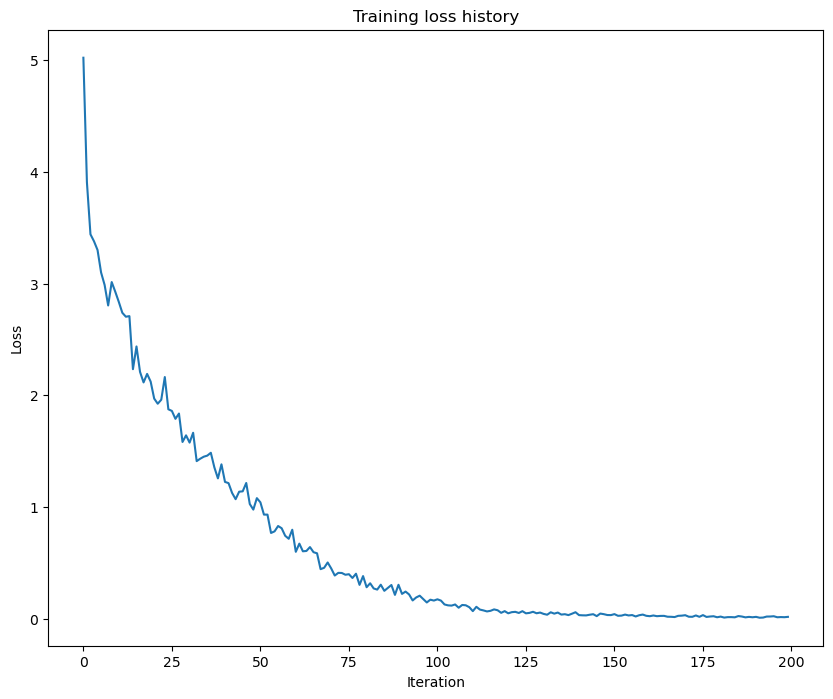

In [64]:
torch.manual_seed(231)
np.random.seed(231)

data = load_coco_data(max_train=50)

transformer = CaptioningTransformer(
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          wordvec_dim=256,
          num_heads=2,
          num_blocks=2,
          max_length=30
        )


transformer_solver = CaptioningSolverTransformer(transformer, data, idx_to_word=data['idx_to_word'],
           num_epochs=100,
           batch_size=25,
           learning_rate=0.001,
           verbose=True, print_every=10,
         )

transformer_solver.train()

# Plot the training losses.
plt.plot(transformer_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [65]:
print('Final loss: ', transformer_solver.loss_history[-1])

Final loss:  0.019938271


URL错误: http://farm1.staticflickr.com/202/487987371_489a65d670_z.jpg


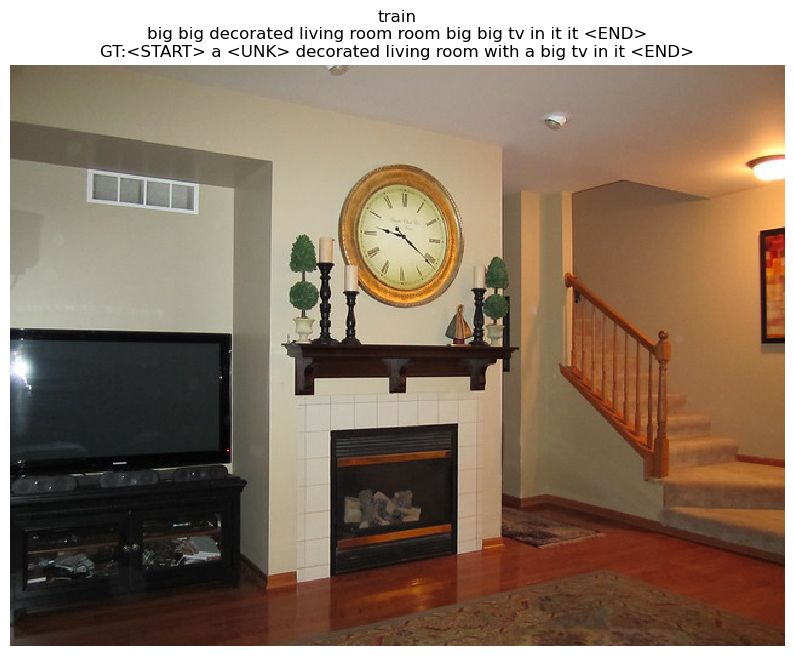

URL错误: http://farm1.staticflickr.com/25/44101107_9491d72776_z.jpg


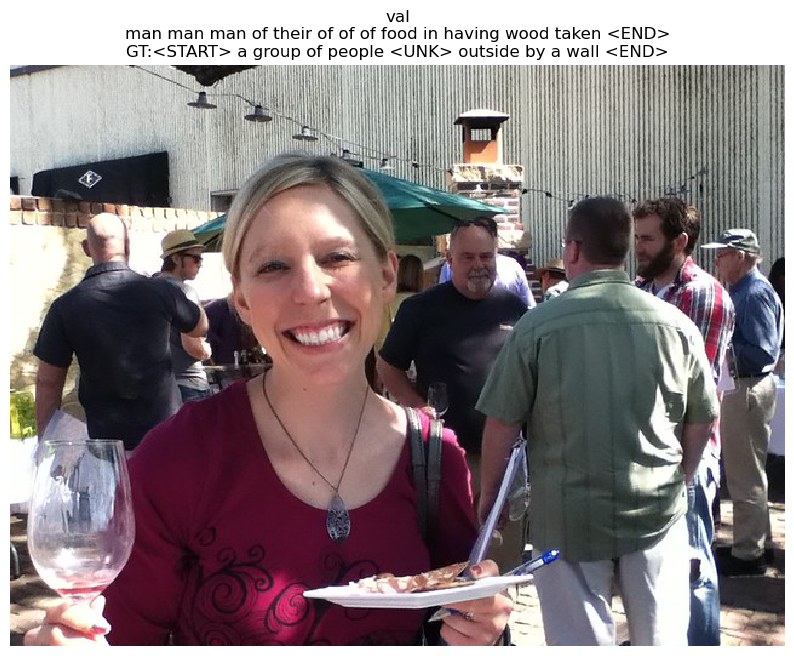

In [66]:
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = transformer.sample(features, max_length=30)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img)            
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

base dir  C:\Users\11834\深度学习_方子森\dl_homework\ex2.Transformer_v3.2\sources\../../datasets_coco/coco_captioning
(Iteration 1 / 200) loss: 5.356487
(Iteration 11 / 200) loss: 2.524180
(Iteration 21 / 200) loss: 2.332731
(Iteration 31 / 200) loss: 1.677147
(Iteration 41 / 200) loss: 1.331085
(Iteration 51 / 200) loss: 0.942673
(Iteration 61 / 200) loss: 0.609964
(Iteration 71 / 200) loss: 0.710559
(Iteration 81 / 200) loss: 0.534030
(Iteration 91 / 200) loss: 0.215019
(Iteration 101 / 200) loss: 0.139055
(Iteration 111 / 200) loss: 0.110930
(Iteration 121 / 200) loss: 0.074732
(Iteration 131 / 200) loss: 0.050664
(Iteration 141 / 200) loss: 0.052047
(Iteration 151 / 200) loss: 0.035997
(Iteration 161 / 200) loss: 0.027383
(Iteration 171 / 200) loss: 0.021089
(Iteration 181 / 200) loss: 0.021503
(Iteration 191 / 200) loss: 0.018585


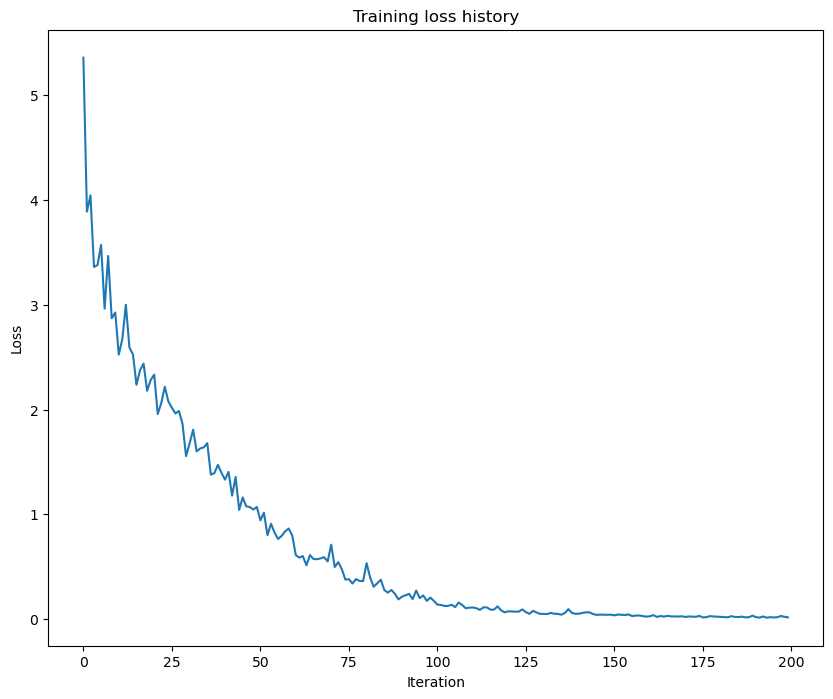

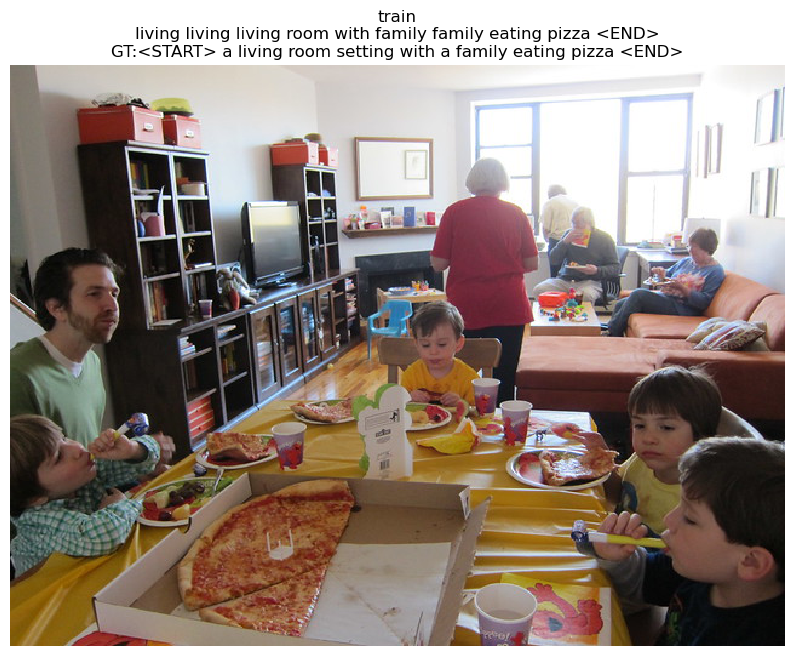

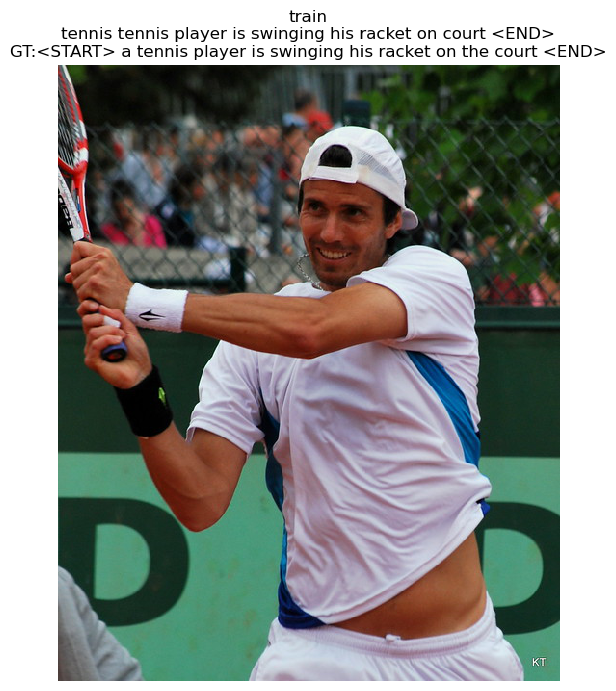

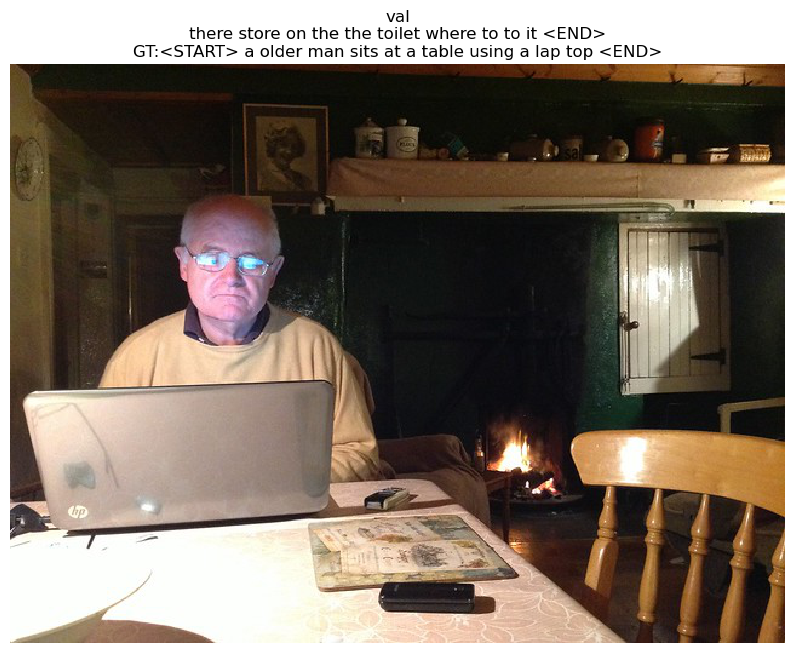

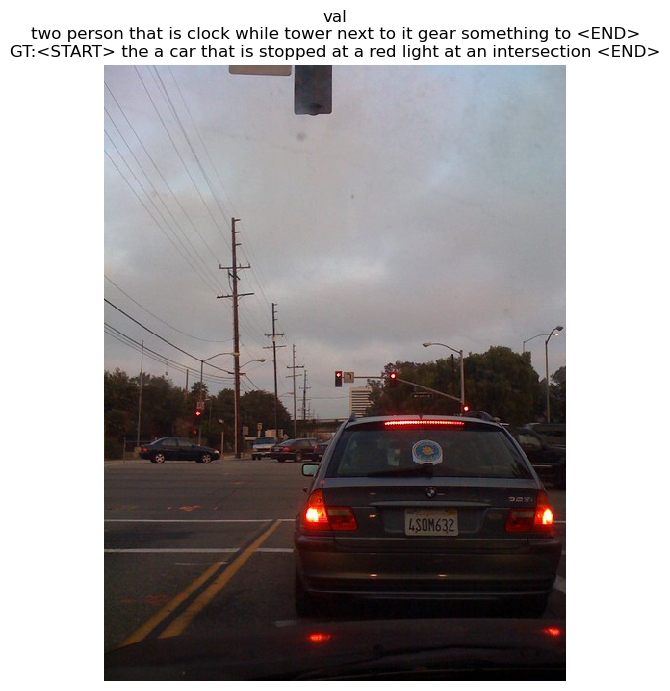

In [67]:
data = load_coco_data(max_train=50)

# change the hyper-parameters below to change the architecture.
transformer = CaptioningTransformer(
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          wordvec_dim=256,
          num_heads=2,
          num_blocks=2,
          max_length=30
        )

# change the parameter
transformer_solver = CaptioningSolverTransformer(transformer, data, idx_to_word=data['idx_to_word'],
           num_epochs=100,
           batch_size=25,
           learning_rate=0.001,
           verbose=True, print_every=10,
         )

transformer_solver.train()

# Plot the training losses.
plt.plot(transformer_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = transformer.sample(features, max_length=30)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img)            
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

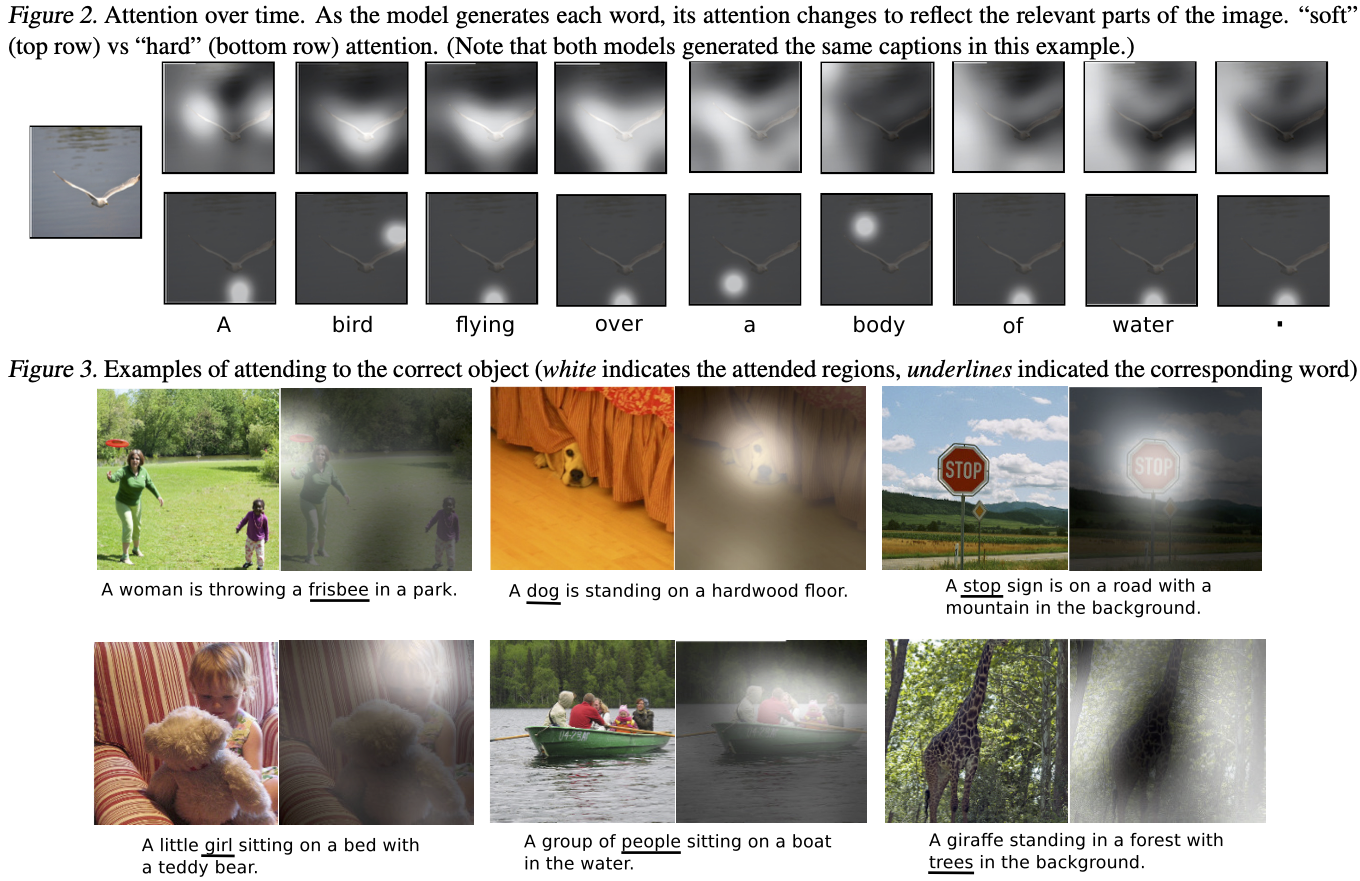

So this is the final task: Visualize the attention weight from your last trained model.
It is a tough task because we didn't prepare any codes for you. 
However, there are a few hints: 
1. Read through `load_coco_data()` and you will find the encoding features come from `fc7` layer in the pretrained `vgg16`. Be careful if you set `pca_features=True`. 
2. If needed, you may change the architecture of `CaptioningTransformer` to better fit the task. For example, the way how the image feature are embeded into Transformer Decoder.
3. Receptive Field may help.

We want you to act like a creative researcher and try your best to independently solve any problem occurring to you. Learn to use web search, you can find answers of any question. When there is no answer, you should create one.
In that case, this will become an interesting task.

HTTP错误(404): http://farm8.staticflickr.com/7108/7789722500_2daf72ac4f_z.jpg
无法加载图片: http://farm8.staticflickr.com/7108/7789722500_2daf72ac4f_z.jpg


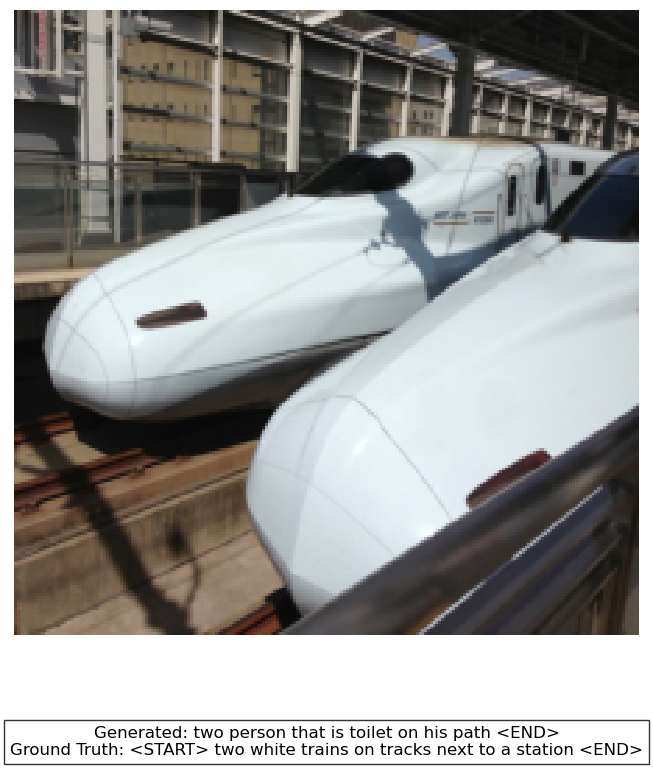

In [70]:
# ​**​*​**START OF YOUR CODE ​**​*​**​


def safe_image_from_url(url):
    """
    安全的图像下载方法（解决Windows临时文件权限问题）
    使用内存流代替临时文件，避免权限冲突
    """
    try:
        # 使用requests库直接下载图像到内存
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            # 使用BytesIO创建内存文件流
            img_data = BytesIO(response.content)
            img = Image.open(img_data)
            return np.array(img)
        else:
            print(f"HTTP错误({response.status_code}): {url}")
            return None
    except Exception as e:
        print(f"图片下载失败: {url}, 错误: {str(e)}")
        return None

# 加载验证集样本
minibatch = sample_coco_minibatch(data, split='val', batch_size=2)
gt_captions, features, urls = minibatch

# 使用模型生成描述
transformer.eval()
with torch.no_grad():
    captions = transformer.sample(features, max_length=30)

# 解码描述
gt_captions = decode_captions(gt_captions, data['idx_to_word'])
sample_captions = decode_captions(captions, data['idx_to_word'])

# 可视化每个样本
for i in range(len(features)):
    img = safe_image_from_url(urls[i])  # 使用安全的下载方法
    if img is None:
        print(f"无法加载图片: {urls[i]}")
        continue
    
    # 改进的图像大小调整方法
    if img.shape[:2] != (224, 224):
        # 使用PIL保持宽高比进行缩放
        pil_img = Image.fromarray(img)
        pil_img = pil_img.resize((224, 224), Image.BILINEAR)  # 双线性插值
        img = np.array(pil_img)
    
    # 显示图像和描述
    plt.figure(figsize=(12, 8))  # 增加高度以容纳标题
    
    # 显示图像
    plt.imshow(img)
    plt.axis('off')
    
    # 在图像下方添加描述文本
    plt.figtext(0.5, 0.05, 
                f"Generated: {sample_captions[i]}\nGround Truth: {gt_captions[i]}", 
                ha='center', fontsize=12, 
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # 增加底部空间
    plt.show()

# ​**​*​**END OF YOUR CODE ​**​*​**​